# Assignment 4 in System Genetics - Gil Sasson & Tomer Schweid

## Loading Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.set_loglevel('WARNING') # Suppresses some information level messages to make the notebook cleaner
import seaborn as sns
import os
import pickle
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.metrics import log_likelihood_score
from joblib import Parallel, delayed
from statsmodels.stats.multitest import fdrcorrection

## Global Variables

These variables are used in several places in the notebook:

In [2]:
# 2Mbp was defined in assignment 3 as the cutoff between cis-acting and trans-acting eQTL, it is used as a threshold for "proximity"
basepair_cutoff = 2000000

# Setting the amount of repetitions for the permutation test
repetitions = 10000

## Loading Data


In [3]:
directory_path = '.' + os.sep + 'data'

# Loading genotype and phenotype data
genotype_df = pd.read_csv(directory_path + os.sep + 'genotypes.txt', sep=",")
phenotype_df = pd.read_csv(directory_path + os.sep + 'phenotypes.txt', sep=",")

# Load QTLs from assignment 2
qtls = pd.read_csv(directory_path + os.sep + 'significant_QTLs.txt', sep=",")

# Load the eQTLs and genes as dataframes from assignment 3
with open(directory_path + os.sep + 'eQTLs_Myeloid Dataset.pkl', 'rb') as file:
    eqtls_myeloid = pickle.load(file)
with open(directory_path + os.sep + 'eQTLs_Liver Dataset.pkl', 'rb') as file:
    eqtls_liver = pickle.load(file)
with open(directory_path + os.sep + 'genes_Myeloid Dataset.pkl', 'rb') as file:
    genes_myeloid = pickle.load(file)
with open(directory_path + os.sep + 'genes_Liver Dataset.pkl', 'rb') as file:
    genes_liver = pickle.load(file)

# Loading gene expression data
analysis_liver = pd.read_csv(directory_path + os.sep + 'analysis_liver.csv')
analysis_myeloid = pd.read_csv(directory_path + os.sep + 'analysis_myeloid.csv')

## - Short Summary of Previous Work and Dataset Explanation

The phenotye we chose to analyze is: "Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death]" (phenotype_id = 787).  
In this assignment we will use:
1. QTLs that were found associated to the phenotype (from assignment 2)
2. eQTLs and their associated genes from the liver and myeloid datasets (from assignment 3)

### 1. Assignment 2 - QTLs analysis

In the second assigment we analyzed BxD mice strains' genotypes data to find a significant association between SNPs and our phenotype. After multiple tests correction (Benjamini-Hochberg, α = 0.05) we found 19 QTLs that are associated with the chosen phenotype.

Here are the QTLs we found:

In [6]:
qtls.drop(columns=['-log(p)', 'p', 'is_significant?', 'corrected_p'], inplace=True)
qtls

KeyError: "['-log(p)', 'p', 'is_significant?', 'corrected_p'] not found in axis"

### Assignment 3 - eQTLs analysis

In the third assignment we analyzed the BxD mice strains' genotypes data to find eQTLs that are associated with genes expression levels in two tissues: myeloid and liver. In the myeloid dataset we found 673 unique eQTLs and in the liver dataset we found 1,435 unique eQTLs. Some of the eQTLs are associated with multiple genes, consequently we found 394 cis-acting eQTLs and 961 trans-acting eQTLs in the myeloid dataset and 1,799 cis-acting eQTLs and 4,910 trans-acting eQTLs in the liver dataset. In both datasets we had genes that were found associated to eQTLs but had no genomic location information and therefore we could not have determined whether they are cis-acting or trans-acting.

Here is a sample data of the eQTL we found (from the myeloid dataset):

In [7]:
print(eqtls_myeloid.head().to_string())

          snp  chromosome   position                                                                          associated genes  associated genes count  relative position
0   rs6404906           4  133563658                [0610009K11Rik, 4931440N07Rik, AI838661, Cd52, Clcnka, Eya3, Sytl1, Tcea3]                       8           0.858320
1  rs13478001           4  135998441                [0610009K11Rik, 4931440N07Rik, AI838661, Cd52, Clcnka, Eya3, Sytl1, Tcea3]                       8           0.873967
2  rs13478002           4  136230564  [0610009K11Rik, 1110005F07Rik, 4930523M17Rik, C79267, Casp9, Cd52, Clcnka, Padi2, Tcea3]                       9           0.875459
3   rs6234904           4  138152372                    [0610009K11Rik, 1110005F07Rik, AI838661, C79267, Casp9, Clcnka, Padi2]                       7           0.887809
4  rs13478021           4  140166294                    [0610009K11Rik, 1110005F07Rik, AI838661, C79267, Casp9, Clcnka, Padi2]                       7

### Assignment 3 - Combined Results

After both analyses we found that 4/19 QTLs in the myeloid dataset and 7/19 QTLs that are also eQTLs. 
In the eQTL analysis we used representative SNPs. Representative SNPs were defined as SNPs that has the exact same genotype data for all BxD strains **AND** are also in close proximity (a distance under 2Mbp). For the QTLs that were not found to be eQTLs we checked whether they are in proximity of those that we did find, making them good candidates to be also eQTLs themselves but the SNPs that were omitted didn't make this possible. When we checked this as well we found that further 12/19 are eQTL suspects in the myeloid dataset and 12/19 are eQTL suspects in the liver dataset.  
If we assume that all of the suspects are eQTLs it would make it a total of 16/19 QTLs that are also eQTLs in the myeloid dataset and 19/19 QTLs that are eQTL in the liver dataset.  
This information could suggest that the QTLs are affecting the phenotype through gene expression regulation in those QTLs and in those tissues. But, there could be also two other possible relations:
1. The QTLs are affecting gene expression and the phenotype independently.
2. The QTL is affecting gene experssion through the phenotype.

## - Apply Causality Test on the Results From Previous Parts

### Creating Triplets for the Test

To test which option is more likely we would run causality tests on triplets of QTL, eQTL associated genes, and phenotype, where the QTL and eQTL associated genes are in proximity.  
To do this we first need to find all eQTLs that are proximal to QTLs:

In [8]:
# Define a function that checks if a QTL is close to an eQTL
def find_proximal_eqtl(row, eqtls):
    '''This function gets a row from a QTL dataframe and a dataframe with eQTLs and returns a list of eQTLs that are in proximity of the QTL'''
    
    qtl_chromosome = row['Chromosome'] # Extracting QTL chromosome
    qtl_position = row['Position'] # Extracting QTL position
    snps = [] # Initializing list

    # Iterate over all eQTLs
    for index, eqtl in eqtls.iterrows():
        
        # Extracting information
        eqtl_name = eqtl['snp'] # Extracting eQTL name
        eqtl_chromosome = eqtl['chromosome'] # Extracting eQTL chromosome
        eqtl_positions = eqtl['position'] # Extracting eQTL position

        # Check if the QTL and eQTL are on the same chromosome
        if qtl_chromosome == eqtl_chromosome:

            # If the distance is less than the threshold set (basepair_cutoff), they are considered proximal
            if abs(qtl_position - eqtl_positions) <= basepair_cutoff:
                snps.append(eqtl_name)
    
    return snps

# Find eQTLs that are proximal to QTLs
qtls['proximal_eqtl_myeloid'] = qtls.apply(find_proximal_eqtl, eqtls=eqtls_myeloid, axis=1)
qtls['proximal_eqtl_liver'] = qtls.apply(find_proximal_eqtl, eqtls=eqtls_liver, axis=1)
qtls[['SNP', 'proximal_eqtl_myeloid', 'proximal_eqtl_liver']]

,SNP,proximal_eqtl_myeloid,proximal_eqtl_liver
0,rs3699934,"[rs13476425, rs3699934]","[rs3699934, rs13476427]"
1,rs13476435,[rs3699934],[rs3699934]
2,rs3709811,[rs3699934],[rs3699934]
3,rs13476448,[rs13476448],"[rs13476448, rs13476456]"
4,CEL-2_39972578,[rs13476448],"[rs13476448, rs13476456]"
5,CEL-2_40063411,[rs13476448],"[rs13476448, rs13476456]"
6,rs6323034,[rs13476448],"[rs13476448, rs13476456]"
7,rs6324652,"[rs13476448, rs13476459]","[rs13476448, rs13476456]"
8,rs13476452,"[rs13476448, rs13476459]","[rs13476448, rs13476456, rs6288325]"
9,rs4136879,"[rs13476448, rs13476459]","[rs13476448, rs13476456, rs6288325]"


Some of the eQTLs are related to more than one QTL. Let's make a list of unique eQTLs:

In [9]:
relevant_eqtls = pd.concat([qtls['proximal_eqtl_myeloid'], qtls['proximal_eqtl_liver']], axis=0).to_list()
relevant_eqtls = [snp for sublist in relevant_eqtls for snp in sublist]
relevant_eqtls = set(relevant_eqtls)
relevant_eqtls

{'CEL-2_50605053',
 'UT_17_75.437568',
 'rs13476425',
 'rs13476427',
 'rs13476448',
 'rs13476456',
 'rs13476459',
 'rs13479451',
 'rs13483106',
 'rs13483110',
 'rs3656948',
 'rs3663088',
 'rs3699934',
 'rs3711721',
 'rs6278585',
 'rs6288325'}

Now we need to extract genes of the proximal eQTLs that are themselves in proximity to the QTL:

In [10]:
# Define a function that gets the genes that are close to the QTL
def find_proximal_genes(eqtls_df, genes_df, qtls_df, data_type):
    """This function gets a dataframe with the eQTLs, a dataframe with the genes, and a dataframe with QTLs
    and returns the QTLs dataframe with a column that contains the genes that are close to the QTL"""
    
    qtls_df[f'cis genes {data_type}'] = pd.Series([[] for _ in range(len(qtls_df.index))]) # Initializing column with empty list
    for index, row in qtls_df.iterrows():
        eqtls = row[f'proximal_eqtl_{data_type}'] # Extracting relevant eQTLs 
        qtl_position = row['Position'] # Extracting QTL position
        for eqtl in eqtls:
            relevant_genes = eqtls_df[eqtls_df['snp'] == eqtl]['associated genes'].values[0] # Extracting relevant genes
            for gene in relevant_genes:
                gene_data = genes_df[genes_df['gene'] == gene]
                if gene_data.empty:
                    continue
                if gene_data['chromosome'].values[0] != row['Chromosome']:
                    continue
                gene_start = gene_data['start position'].values[0]
                gene_end = gene_data['end position'].values[0]
                if min(abs(gene_start - qtl_position), abs(gene_end - qtl_position)) <= basepair_cutoff:
                    qtls_df.at[index, f'cis genes {data_type}'] = qtls_df.at[index, f'cis genes {data_type}'] + [gene]
    return qtls_df

qtls = find_proximal_genes(eqtls_myeloid, genes_myeloid, qtls, 'myeloid')
qtls = find_proximal_genes(eqtls_liver, genes_liver, qtls, 'liver')

print(qtls[['SNP', 'cis genes myeloid', 'cis genes liver']].to_string())

               SNP cis genes myeloid                                                                                                                                                                                                                                                                                                                                                                                                                                                                   cis genes liver
0        rs3699934                []                                                                                                                                                                                                                                                                                                                                                                                                                                      [hemolytic complement, hemolytic comple

Here we convert the data structure from pandas dataframe into a dictionary.  
Dictionary is created per dataset and contains QTLs as keys and the list of relevant genes as values (genes of eQTLs were both eQTL and gene are proximal to that QTL):

In [11]:
# Create a dictionary that maps each QTL to its associated genes
def qtl_gene_dict(qtls, tissue):
    """ This function gets a dataframe with the QTLs, a dataframe with the eQTLs, and a tissue name and returns a dictionary that maps each QTL to its associated genes 
    """

    qtl_gene_dict = {} # Initializing dictionary

    for index, row in qtls.iterrows():
        qtl_name = row['SNP'] # Extracting QTL name 
        qtl_gene_dict[qtl_name] = qtls.at[index, f'cis genes {tissue}'] # Extracting relevant genes
        
        # Deleting QTLs that has no related genes
        if len(qtl_gene_dict[qtl_name]) == 0:
            del qtl_gene_dict[qtl_name] 
    qtl_gene_dict = {k: list(set(v)) for k, v in qtl_gene_dict.items()}
    return qtl_gene_dict

qtl_gene_dict_liver = qtl_gene_dict(qtls, 'liver')
qtl_gene_dict_myeloid = qtl_gene_dict(qtls, 'myeloid')

print(qtl_gene_dict_myeloid)
print(qtl_gene_dict_liver)

{'rs13479451': ['Ppfibp2'], 'rs3724540': ['Ppfibp2'], 'rs6386601': ['Ppfibp2']}
{'rs3699934': ['hemolytic complement'], 'CEL-2_50605053': ['Rap1 interacting factor 1 homolog (yeast)'], 'rs13476490': ['Rap1 interacting factor 1 homolog (yeast)'], 'rs13479451': ['olfactomedin-like 1'], 'rs3724540': ['olfactomedin-like 1'], 'rs6386601': ['olfactomedin-like 1'], 'rs3656948': ['fasciculation and elongation protein zeta 2 (zygin II)', 'cysteine rich transmembrane BMP regulator 1 (chordin like)'], 'rs6278585': ['fasciculation and elongation protein zeta 2 (zygin II)', 'cysteine rich transmembrane BMP regulator 1 (chordin like)'], 'rs3717212': ['fasciculation and elongation protein zeta 2 (zygin II)', 'cysteine rich transmembrane BMP regulator 1 (chordin like)']}


### Preparing Data for Causality Analysis

Now let's create a dataframe (per dataset) which contains columns of QTL genotype, gene expression levels and the phenotype. Data is ordered where QTL and gene are next to one another and the phenotype is the last column. If QTL is associated with more than one gene or a gene is associated with more than one QTL it would look differently but that wouldn't affect the analysis later since the mapping is saved in the dictionaries we created earlier.

In [12]:
# Create the analysis dataframe
def create_analysis_df(qtl_gene_dict, values_df, genotypes_df):
    '''This function gets a dictionary that maps SNPs to genes, a dataframe with the gene expression values,
    and a dataframe with the genotypes and returns a dataframe with the relevant SNPs, genes, and the phenotype values'''
    
    genotypes_df = genotypes_df.set_index('Locus')
    genotypes_df.drop(columns=['0', "Chr_Build37", "Build37_position"], inplace=True)
    relevant_strains = values_df.columns
    genotypes_df = genotypes_df.loc[:, relevant_strains]
    analysis_df = pd.DataFrame(index=values_df.columns)
    
    # Add the SNPs and genes columns
    for snp in qtl_gene_dict.keys():
        analysis_df[snp] = genotypes_df.loc[snp]
        for gene in qtl_gene_dict[snp]:
            analysis_df[gene] = values_df.loc[gene]
    
    # Add the phenotype column
    analysis_df['Phenotype'] = phenotype_df.iloc[787, :]
    analysis_df = analysis_df.dropna()
    return analysis_df

# Set the index of the analysis dataframes to the gene name
analysis_myeloid = analysis_myeloid.set_index('Symbol')
analysis_liver = analysis_liver.set_index('GENE_NAME')

# Preparing dataframes for analysis
analysis_df_myeloid = create_analysis_df(qtl_gene_dict_myeloid, analysis_myeloid, genotype_df)
analysis_df_liver = create_analysis_df(qtl_gene_dict_liver, analysis_liver, genotype_df)

print(analysis_df_myeloid.head().to_string())
print(analysis_df_liver.head().to_string())

      rs13479451   Ppfibp2  rs3724540  rs6386601 Phenotype
BXD1           0  6.729917          0          0      66.7
BXD2           0  6.679828          0          0       0.0
BXD6           0  6.797566          0          0      50.0
BXD8           0  6.464898          0          0       0.0
BXD9           2  7.110817          2          2     100.0
      rs3699934  hemolytic complement  CEL-2_50605053  Rap1 interacting factor 1 homolog (yeast)  rs13476490  rs13479451  olfactomedin-like 1  rs3724540  rs6386601  rs3656948  fasciculation and elongation protein zeta 2 (zygin II)  cysteine rich transmembrane BMP regulator 1 (chordin like)  rs6278585  rs3717212 Phenotype
BXD1          2                1.1480               2                                  -0.127167           2           0               0.8930          0          0          0                                                 -0.1370                                                     -0.8140          0          0      66.7


### Running Causality Tests

These are functions that will run the tests:

In [13]:
# Define the causality test function
def causality_test(data, snp, gene, permutation=False):
    '''This function gets a dataframe and two columns names, one for the snp and one for the gene,
    and returns the likelihood of the 3 possible Bayesian Networks structures:
        1. SNP -> Gene -> Phenotype
        2. SNP -> Phenotype -> Gene
        3. Phenotype <- SNP -> Gene
    The function has an optional flag to permutate the data which is disabled by default.
    '''

    triplet_df = data[[snp, gene, 'Phenotype']].copy()

    # If run in permutation mode, permutate the data
    if permutation:
        triplet_df = triplet_df.apply(np.random.permutation) # Scrambling all columns in the myeloid dataframe

    # Discretize the gene expression, we divide it to 3 levels (low, medium, high) - each level is a third of the range of provided values
    # Calculating bins
    min_value = triplet_df.loc[:, gene].min()
    max_value = triplet_df.loc[:, gene].max()
    value_range = max_value - min_value
    value_bin_width = value_range / 3
    bins = [min_value - 1, (min_value + value_bin_width), (min_value + (2 * value_bin_width)), max_value]
    # Discretizing the data
    triplet_df.loc[:, gene] = pd.cut(triplet_df.loc[:, gene], bins=bins, labels=list(range(len(bins) - 1))).astype(int)
    

    # Discretize the phenotype, we divide it to 3 levels (low, medium, high) - each level is a third of the range of provided values
    # Calculating bins
    min_value = triplet_df.loc[:, 'Phenotype'].min()
    max_value = triplet_df.loc[:, 'Phenotype'].max()
    value_range = max_value - min_value
    value_bin_width = value_range / 3
    bins = [min_value - 1, (min_value + value_bin_width), (min_value + (2 * value_bin_width)), max_value]
    # Discretizing the data
    triplet_df.loc[:, 'Phenotype'] = pd.cut(triplet_df.loc[:, 'Phenotype'], bins=bins, labels=list(range(len(bins) - 1))).astype(int)
    
    # Define the 3 possible structures for the Bayesian Network
    edges_1 = [(snp, gene), (gene, 'Phenotype')] # 1. SNP -> Gene -> Phenotype
    edges_2 = [(snp, 'Phenotype'), ('Phenotype', gene)] # 2. SNP -> Phenotype -> Gene
    edges_3 = [(snp, gene), (snp, 'Phenotype')] # 3. Phenotype <- SNP -> Gene

    # Create the models
    model_1 = BayesianNetwork(edges_1)
    model_2 = BayesianNetwork(edges_2)
    model_3 = BayesianNetwork(edges_3)
    
    # Fit the models
    model_1.fit(triplet_df, estimator=MaximumLikelihoodEstimator)
    model_2.fit(triplet_df, estimator=MaximumLikelihoodEstimator)
    model_3.fit(triplet_df, estimator=MaximumLikelihoodEstimator)
    
    # Calculate the likelihood
    likelihood_1 = np.exp(log_likelihood_score(model_1, triplet_df))
    likelihood_2 = np.exp(log_likelihood_score(model_2, triplet_df))
    likelihood_3 = np.exp(log_likelihood_score(model_3, triplet_df))
    
    return likelihood_1, likelihood_2, likelihood_3


# Define a function that runs the causality test for all SNP-Gene pairs
def run_causality_tests(data, snp_gene_pairs, permutation=False):
    '''This function gets a dataframe and a dictionary that maps SNPs to genes and returns
    the likelihood of the 3 possible Bayesian Networks structures for each SNP-Gene pair.
    The function has an optional flag to permutate the data which is disabled by default.'''
    
    results = {}
    for snp in snp_gene_pairs.keys():
        for gene in snp_gene_pairs[snp]:
            results[(snp, gene)] = causality_test(data, snp, gene, permutation)
    return results

Running causaility test for the myeloid dataset:

In [14]:
# Run the causality tests for the myeloid dataset
results_myeloid = run_causality_tests(analysis_df_myeloid, qtl_gene_dict_myeloid)

# Reorganizing results dataframe
results_myeloid = pd.DataFrame(results_myeloid).T # Transposing dataframe
results_myeloid.columns = ['model 1 likelihood', 'model 2 likelihood', 'model 3 likelihood'] # Setting column names
results_myeloid['best model'] = results_myeloid.idxmax(axis=1) # Adding a column with the best model (maximal likelihood)
results_myeloid['best model'] = results_myeloid['best model'].str.replace('model ', '') # Removing 'model ' from the 'best model' column, the goal is to have only the number of the model
results_myeloid['best model'] = results_myeloid['best model'].str.replace(' likelihood', '') # Removing ' likelihood' from the 'best model' column, the goal is to have only the number of the model
print(results_myeloid.head().to_string())

                    model 1 likelihood  model 2 likelihood  model 3 likelihood best model
rs13479451 Ppfibp2        2.618061e-18        3.321314e-22        1.224481e-18          1
rs3724540  Ppfibp2        2.618061e-18        3.321314e-22        1.224481e-18          1
rs6386601  Ppfibp2        2.618061e-18        3.321314e-22        1.224481e-18          1


Running causaility test for the liver dataset:

In [15]:
# Run the causality tests for the myeloid dataset
results_liver = run_causality_tests(analysis_df_liver, qtl_gene_dict_liver)

# Reorganizing results dataframe
results_liver = pd.DataFrame(results_liver).T # Transposing dataframe
results_liver.columns = ['model 1 likelihood', 'model 2 likelihood', 'model 3 likelihood'] # Setting column names
results_liver['best model'] = results_liver.idxmax(axis=1) # Adding a column with the best model (maximal likelihood)
results_liver['best model'] = results_liver['best model'].str.replace('model ', '') # Removing 'model ' from the 'best model' column, the goal is to have only the number of the model
results_liver['best model'] = results_liver['best model'].str.replace(' likelihood', '') # Removing ' likelihood' from the 'best model' column, the goal is to have only the number of the model
print(results_liver.head().to_string())

                                                          model 1 likelihood  model 2 likelihood  model 3 likelihood best model
rs3699934      hemolytic complement                             2.090439e-32        7.630337e-37        4.410124e-32          3
CEL-2_50605053 Rap1 interacting factor 1 homolog (yeast)        4.087974e-35        1.141177e-38        3.107066e-35          1
rs13476490     Rap1 interacting factor 1 homolog (yeast)        4.087974e-35        1.141177e-38        3.107066e-35          1
rs13479451     olfactomedin-like 1                              4.508655e-42        5.545986e-45        1.086204e-40          3
rs3724540      olfactomedin-like 1                              4.508655e-42        5.545986e-45        1.086204e-40          3


Create visualization to see how many times each model was chosen as the best model:

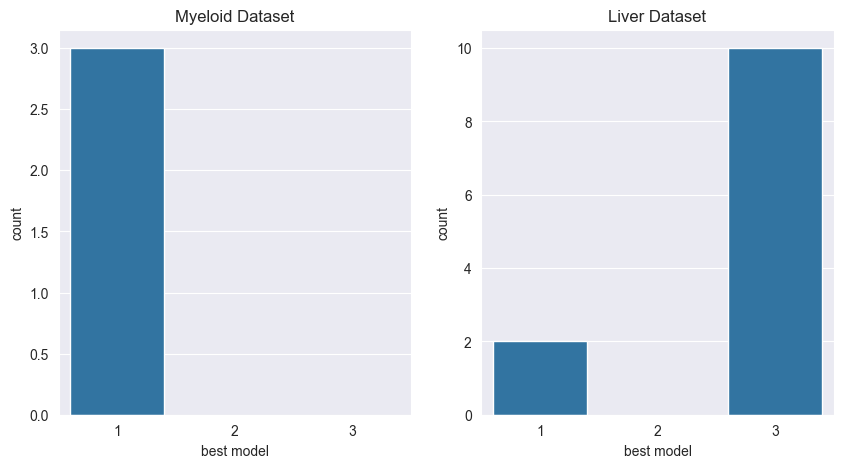

In [16]:
# Count the number of times each model was selected
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=results_myeloid, x='best model', order=['1', '2', '3'])
plt.title('Myeloid Dataset')
plt.subplot(1, 2, 2)
sns.countplot(data=results_liver, x='best model', order=['1', '2', '3'])
plt.title('Liver Dataset')
plt.show()

## - Report the Predicted Relations Among the QTL, Associated Gene, and Phenotype

It seems that for both datasets we recived one of two models:
* Model 1 - where the SNP is the parent of the gene and the gene is the parent of the phenotype. This structure suggests that the SNP is affecting the gene expression and the gene expression is affecting the phenotype. This result is consistent with the hypothesis that the QTLs are affecting the phenotype through gene expression regulation in those QTLs and in those tissues.
* Model 3 - where the SNP is the parent of the gene and phenotype. This structure suggests that the QTL is also an eQTL, and that it affects both the phenotype and gene expression directly (and does not affect the phenotype via gene expression)

## - Run the Test on 10 Triplets
*Explain the choice you made and the design of permutation test in detail*

In our permutation test we try to see whether the best model we found is significant. For this we calculate log likelihood ratio (LLR) for each triplet, and then see where it falls within the distribution of LLR's under the null hypothesis: the chosen model have no more explanitory basis, and there is no relation between the SNP, gene and phenotype, or it is a different one than the one we found.
To simulate the null hypothesis we permutate the data for the SNP genotype, gene expression and the phenotype. We then try to see if the model we chose best for this triplet is still the best from all three and in how much (we calculate LLR for the scrambeled triplet).

First, we need to choose 10 triplets of SNP, gene and phenotype to test for thier significance using permutation test.  
We are chosing the 10 triplets with the highest LLR.  
The following function calculates the LLR for any given triplet:

In [17]:
def calculate_log_likelihood_ratio(row):
    if row['best model'] == '1':
        log_likelihood_ratio = np.log(row['model 1 likelihood'] / row[['model 2 likelihood', 'model 3 likelihood']].max())
    elif row['best model'] == '2':
        log_likelihood_ratio = np.log(row['model 2 likelihood'] / row[['model 1 likelihood', 'model 3 likelihood']].max())
    elif row['best model'] == '3':
        log_likelihood_ratio = np.log(row['model 3 likelihood'] / row[['model 1 likelihood', 'model 2 likelihood']].max())

    return log_likelihood_ratio

Let's extract the LLR and look at the top ones:

In [18]:
# Calculating log likelihood ratio
results_myeloid['log likelihood ratio'] = results_myeloid.apply(calculate_log_likelihood_ratio, axis=1)
results_liver['log likelihood ratio'] = results_liver.apply(calculate_log_likelihood_ratio, axis=1)

Top myeloid log likelihood ratio:

In [19]:
print(results_myeloid.sort_values('log likelihood ratio', ascending=False).head(10).to_string())

                    model 1 likelihood  model 2 likelihood  model 3 likelihood best model  log likelihood ratio
rs13479451 Ppfibp2        2.618061e-18        3.321314e-22        1.224481e-18          1              0.759917
rs3724540  Ppfibp2        2.618061e-18        3.321314e-22        1.224481e-18          1              0.759917
rs6386601  Ppfibp2        2.618061e-18        3.321314e-22        1.224481e-18          1              0.759917


We can see that all triplets in the myeloid dataset has excatly the same values across all columns, and that they are all related to the same gene with a different QTLs loci:
Let's look at the QTL:

In [20]:
for index in results_myeloid.index:
    print(qtls[qtls['SNP'] == index[0]][['Chromosome', 'Position']])

    Chromosome     Position
12           7  114512549.0
    Chromosome     Position
13           7  114542346.0
    Chromosome     Position
14           7  114746367.0


We can see that the QTLs are very close (less than 250Kbp from one another), suggesting that all of them are markers for one locus. We will choose the first one to represent all three of them.

Top liver log likelihood ratio:

In [21]:
print(results_liver.sort_values('log likelihood ratio', ascending=False).head(10).to_string())

                                                                       model 1 likelihood  model 2 likelihood  model 3 likelihood best model  log likelihood ratio
rs3656948  cysteine rich transmembrane BMP regulator 1 (chordin like)        1.479703e-40        5.483971e-42        3.812444e-39          3              3.249014
rs13479451 olfactomedin-like 1                                               4.508655e-42        5.545986e-45        1.086204e-40          3              3.181860
rs3724540  olfactomedin-like 1                                               4.508655e-42        5.545986e-45        1.086204e-40          3              3.181860
rs6386601  olfactomedin-like 1                                               4.508655e-42        5.545986e-45        1.086204e-40          3              3.181860
rs6278585  cysteine rich transmembrane BMP regulator 1 (chordin like)        5.026471e-39        3.213523e-42        5.564794e-38          3              2.404327
rs3717212  cysteine ri

We see that the best 10 triplets are 1 of the myeloid and the top 9 of the liver. Let's take the top 9 from the liver dataset and create a new dictionary for the causality test.

In [22]:
# Initializing variables
permutation_qtl_gene_dict_liver = {} # Initializing dictionary
results_permutation = results_liver.sort_values('log likelihood ratio', ascending=False).head(9).copy() # Initializing dataframe

# Populating dictionary from the top 9 log likelihood ratios of SNP-gene-phenotype triplets
for index, _ in results_permutation.iterrows():
    
    # Extracting information
    snp_name  = index[0] # Extracting SNP name
    gene_name = index[1] # Extracting gene name

    # Adding gene to the list of associated
    try:
        permutation_qtl_gene_dict_liver[snp_name].append(gene_name)
    
    # If list of associated genes doesn't exist - initialize it first
    except:
        permutation_qtl_gene_dict_liver[snp_name] = [] # Initializing list of associated genes
        permutation_qtl_gene_dict_liver[snp_name].append(gene_name)

permutation_qtl_gene_dict_liver

{'rs3656948': ['cysteine rich transmembrane BMP regulator 1 (chordin like)',
  'fasciculation and elongation protein zeta 2 (zygin II)'],
 'rs13479451': ['olfactomedin-like 1'],
 'rs3724540': ['olfactomedin-like 1'],
 'rs6386601': ['olfactomedin-like 1'],
 'rs6278585': ['cysteine rich transmembrane BMP regulator 1 (chordin like)',
  'fasciculation and elongation protein zeta 2 (zygin II)'],
 'rs3717212': ['cysteine rich transmembrane BMP regulator 1 (chordin like)'],
 'rs3699934': ['hemolytic complement']}

## - Apply Permutation Test to Get Statistical Significance For One or a Few Specific Causality Hypotheses

let's write a function for the permutation test:

In [23]:
def run_permutation_causality_tests(df, qtl_gene_dict, comparison_models):
    
    # Run the causality test in permutation mode
    df = run_causality_tests(df, qtl_gene_dict, permutation=True)

    # Reorganizing dataframe
    df = pd.DataFrame(df).T # Transposing dataframe
    df.columns = ['model 1 likelihood', 'model 2 likelihood', 'model 3 likelihood'] # Setting column names
    df['best model'] = comparison_models # The model which was found as best in the unpermutated data

    # Calculating log likelihood ratio
    df['log likelihood ratio'] = df.apply(calculate_log_likelihood_ratio, axis=1) # Calculating log likelihood ratio
    
    # Returning a numpy array with the log likelihood ratio of the permutations for each triplet
    return df['log likelihood ratio'].to_numpy()

Now let's run the permutation test in a for loop. Running for liver triplets (top 9):

In [24]:
# Initializing results matrix
triplet_count = sum(len(value) for value in permutation_qtl_gene_dict_liver.values())
permutation_llr_results_liver = np.zeros((triplet_count, repetitions))  # Preallocate memory

# Extracting the model we need to compare to:
comparison_models = [] # Initializing list
for snp in permutation_qtl_gene_dict_liver:
    for gene in permutation_qtl_gene_dict_liver[snp]:
        comparison_models.append(results_liver.at[(snp, gene), 'best model'])

# Define a function to run a single repetition
def run_single_repetition_liver(rep):
    return run_permutation_causality_tests(analysis_df_liver, permutation_qtl_gene_dict_liver, comparison_models)

# Run the permutation tests in parallel (using all available cores)
permutation_results_liver = Parallel(n_jobs=-1)(delayed(run_single_repetition_liver)(rep) for rep in range(repetitions))

# Store the results
for repetition in range(repetitions):
        permutation_llr_results_liver[:, repetition] = permutation_results_liver[repetition]

Running for myeloid triplet:

In [25]:
# Manually setting the triplet
permutation_qtl_gene_dict_myeloid = {'rs13479451': ['Ppfibp2']}

# Initializing results matrix
triplet_count = sum(len(value) for value in permutation_qtl_gene_dict_myeloid.values())
permutation_llr_results_myeloid = np.zeros((triplet_count, repetitions))  # Preallocate memory

# Extracting the model we need to compare to:
comparison_models = [] # Initializing list
for snp in permutation_qtl_gene_dict_myeloid:
    for gene in permutation_qtl_gene_dict_myeloid[snp]:
        comparison_models.append(results_myeloid.at[(snp, gene), 'best model'])

# Define a function to run a single repetition
def run_single_repetition_myeloid(rep):
    return run_permutation_causality_tests(analysis_df_myeloid, permutation_qtl_gene_dict_myeloid, comparison_models)

# Run the permutation tests in parallel (using all available cores)
permutation_results_myeloid = Parallel(n_jobs=-1)(delayed(run_single_repetition_myeloid)(rep) for rep in range(repetitions))

# Store the results
for repetition in range(repetitions):
    permutation_llr_results_myeloid[:, repetition] = permutation_results_myeloid[repetition]


Adding both results to one matrix, and adding results permutation dataframes:

In [26]:
permutation_llr_results = np.concat([permutation_llr_results_liver, permutation_llr_results_myeloid], axis=0) # Creating combined llr results matrix 
results_permutation = pd.concat([results_liver.sort_values('log likelihood ratio', ascending=False).head(9).copy(), results_myeloid.head(1)], axis=0) # Creating combined results dataframe

Great, let's plot the results to see if we have any significant findings:

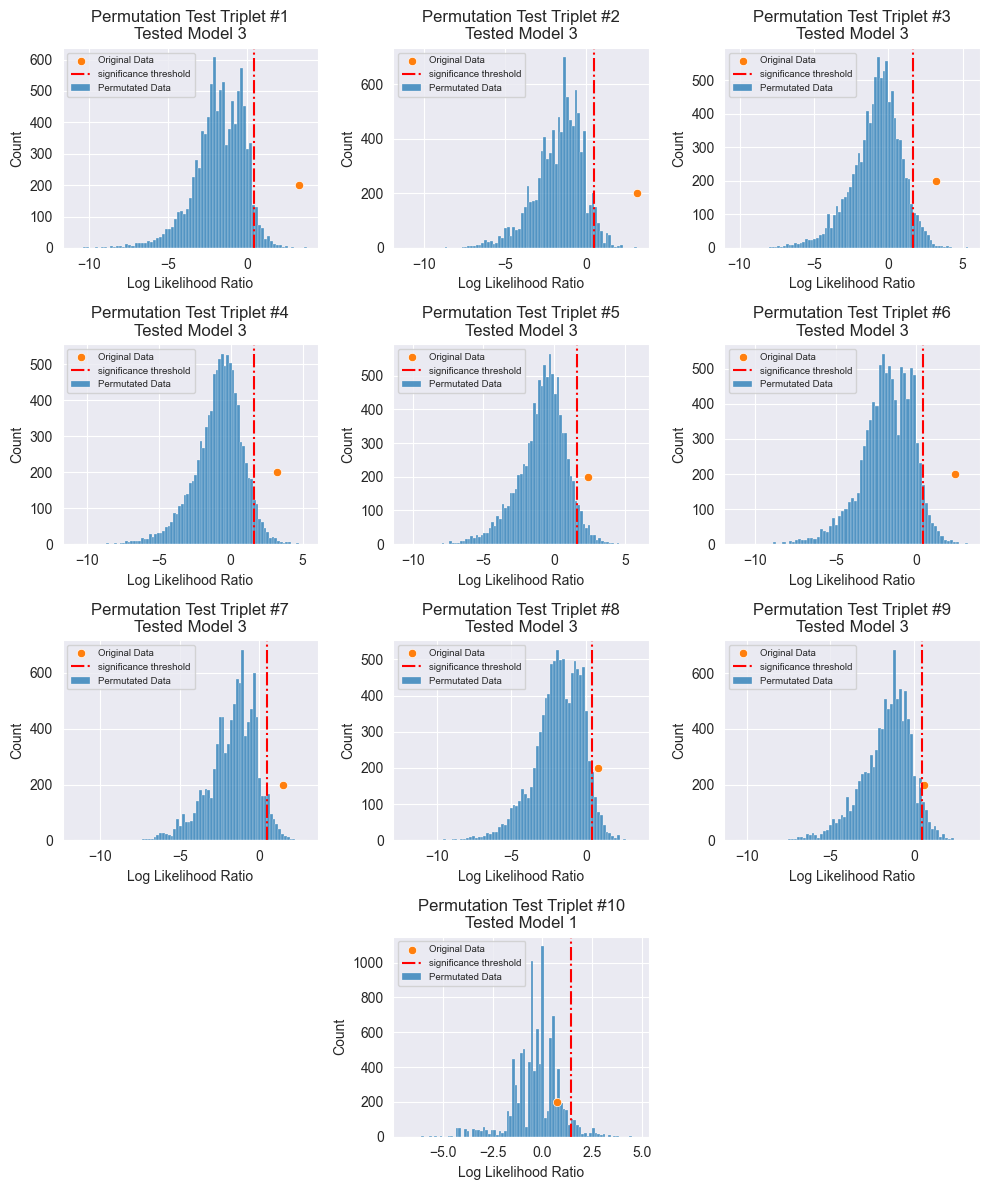

In [27]:
triplets_llr = results_permutation['log likelihood ratio'].to_numpy() # Extracting the log likelihood ratio of the original data 

# Initializing subplots
fig = plt.figure(figsize=(10, 12)) # Creating a figure
gs = gridspec.GridSpec(4, 3, figure=fig) # Creating subplots grid

# Initializing p_10-value vector
triplet_p_value = []

# Plotting for each triplet
for triplet in range(permutation_llr_results.shape[0]):
    
    # Ordering LLR (x axis)
    permutation_llr = sorted(permutation_llr_results[triplet, :])  # Ordering permutated data
    significance_threshold = permutation_llr[round(len(permutation_llr) * 0.95)] # Extracting the value of the significance threshold (95% - α = 0.05)

    # Adding p_10-value of the original data to list
    triplet_insertion_index = np.searchsorted(permutation_llr, triplets_llr[triplet])  # Get the index where the original data would be inserted to maintain order
    permutation_percentile = (np.array(range(1, len(permutation_llr) + 1)) / len(permutation_llr)) * 100 # Calculating percentile for the permutated data
    
    # If original data is bigger than all permutated data 
    if triplet_insertion_index == len(permutation_llr):
        p = 0 # The probability of getting a higher value from the permutated data distribution is 0 since it is the highest value
    else:
        p = float(round(100 - permutation_percentile[triplet_insertion_index], 3)) / 100 # Calculating p_10 value of the original data in the permutated data distribution
    triplet_p_value.append(p)

    # Creating a pandas dataframe for the seaborn scatter plot
    plot_data = pd.DataFrame({'percentile': permutation_percentile, 'LLR': permutation_llr, 'type': (['permutation'] * len(permutation_percentile))})
    plot_data.loc[triplet_insertion_index, 'type'] = 'original'

    # Plotting data
    if triplet < 9:
        ax = fig.add_subplot(gs[triplet])  # Create subplot for the first 9 plots
    else:
        ax = fig.add_subplot(gs[triplet // 3, 1:2])  # Center the 10th plot (on the last row, middle column)
    
    sns.histplot(data=plot_data, x='LLR', ax=ax, log_scale=False, label='Permutated Data') # Plotting  permutated data

    # Adding the original data to the plot
    scatterplot_data = pd.DataFrame({'LLR': [triplets_llr[triplet]], 'y': [permutation_llr_results.shape[1] / 50]})
    sns.scatterplot(data=scatterplot_data, x='LLR', y='y', ax=ax, label='Original Data') # Plotting
    
    # Plot customization
    ax.set_title(f'Permutation Test Triplet #{triplet + 1}\nTested Model {results_permutation.iloc[triplet]["best model"]}')  # Adding a title
    ax.axvline(x=significance_threshold, color='r', label='significance threshold', linestyle='-.')  # Adding significance threshold
    ax.set_xlabel('Log Likelihood Ratio')  # Adding x-axis title

    # Adding legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, fontsize='x-small')


# Removing unused plots
fig.add_subplot(gs[10]).axis('off')
fig.add_subplot(gs[11]).axis('off')

# Showing plots
plt.tight_layout()
plt.show()

Let's also correct for multiple testing and print the corrected p values:

In [28]:
# Correcting for multiple tests:
corrected_p_values = fdrcorrection(triplet_p_value)[1]
for triplet in range(permutation_llr_results.shape[0]):

    # Extracting triplet names
    snp_name =  results_permutation.iloc[triplet].name[0]
    gene_name =  results_permutation.iloc[triplet].name[1]
    report = f'{snp_name}, {gene_name}'

    # Printing p_10-value infomation
    print(f'triplet: {report}:')
    print(f'p_10-value: {triplet_p_value[triplet]}\tcorrected p_10-value: {corrected_p_values[triplet]}')

triplet: rs3656948, cysteine rich transmembrane BMP regulator 1 (chordin like):
p_10-value: 0.0001	corrected p_10-value: 0.0005
triplet: rs13479451, olfactomedin-like 1:
p_10-value: 0	corrected p_10-value: 0.0
triplet: rs3724540, olfactomedin-like 1:
p_10-value: 0.0031	corrected p_10-value: 0.007749999999999999
triplet: rs6386601, olfactomedin-like 1:
p_10-value: 0.0046	corrected p_10-value: 0.009166666666666668
triplet: rs6278585, cysteine rich transmembrane BMP regulator 1 (chordin like):
p_10-value: 0.0165	corrected p_10-value: 0.023571428571428573
triplet: rs3717212, cysteine rich transmembrane BMP regulator 1 (chordin like):
p_10-value: 0.0013	corrected p_10-value: 0.004333333333333333
triplet: rs3656948, fasciculation and elongation protein zeta 2 (zygin II):
p_10-value: 0.0055000000000000005	corrected p_10-value: 0.009166666666666668
triplet: rs3699934, hemolytic complement:
p_10-value: 0.0256	corrected p_10-value: 0.032
triplet: rs6278585, fasciculation and elongation protein z